In [1]:
#Notebook taken and modified from https://nbviewer.org/url/arteagac.github.io/blog/lime_image.ipynb

import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import os
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

2024-03-04 03:05:38.720056: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
folder = 'pickle'
inner_folder = 'augmented_2'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)

2024-03-04 03:05:41.543626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 03:05:41.572996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 03:05:41.573468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

In [3]:
class_names = ["ABE", "ART", "BAS", "BLA", "EBO", "EOS", "FGC", "KSC", "LYI", "LYT", "MMZ", "MON", "MYB", "NGB", "NGS", "NIF", "OTH", "PEB", "PLM", "PMO"]

In [36]:
img = skimage.io.imread("Validation/MYB/MYB_00005.jpg")
yhat = model.predict(np.expand_dims(img/255, 0))

1/1 [==============================] - 0s 17ms/step


In [37]:
superpixels = skimage.segmentation.quickshift(img, kernel_size=4,max_dist=200, ratio=0.2)
print(superpixels)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

[[ 1  1  1 ...  0  0  0]
 [ 1  1  1 ...  0  0  0]
 [ 1  1  1 ...  0  0  0]
 ...
 [37 37 37 ... 40 40 40]
 [37 37 37 ... 40 40 40]
 [37 37 37 ... 40 40 40]]


43

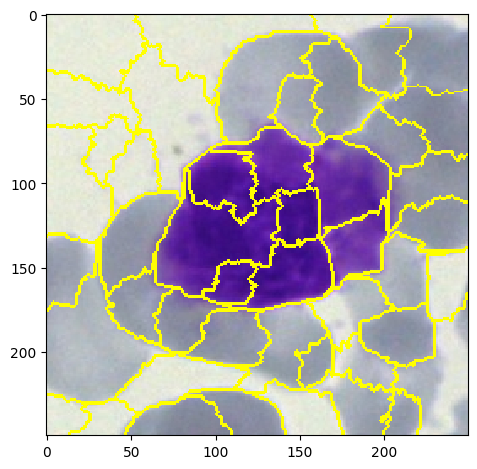

In [6]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(img, superpixels))

In [7]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1])

In [16]:
def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image * mask[:, :, np.newaxis]
    perturbed_image += (1 - mask[:, :, np.newaxis]) * 128
    
    # Normalize to the range [0, 1]
    perturbed_image = perturbed_image / 255.0
    return perturbed_image

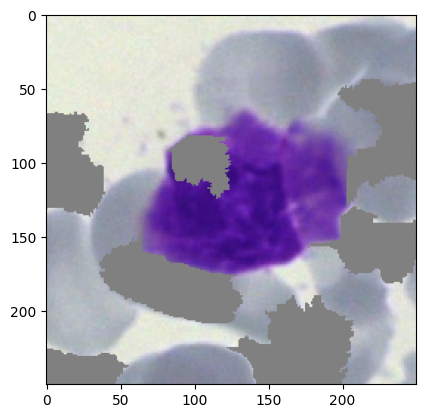

In [18]:
plt.imshow(perturb_image(img, perturbations[0], superpixels))
plt.show()

In [19]:
perturbed_img = perturb_image(img,perturbations[0],superpixels)
yhat = model.predict(perturbed_img[np.newaxis,:,:,:])
max_index = np.argmax(yhat)
yhat
# max_index
# print(class_names[max_index])

1/1 [==============================] - 0s 97ms/step


array([[4.34072410e-15, 7.20820487e-01, 1.57699658e-04, 1.18530286e-03,
        3.48494505e-05, 1.19709007e-01, 1.49699531e-06, 6.23264077e-06,
        4.15472550e-06, 1.89172663e-02, 2.16899104e-02, 2.34233611e-03,
        5.93048893e-03, 9.81888035e-04, 1.36715295e-02, 9.05149728e-02,
        3.31908138e-03, 5.43587958e-04, 1.91893105e-06, 6.22117150e-05,
        1.05678846e-04]], dtype=float32)

In [20]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(img,pert,superpixels)
    pred = model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 17ms/step


(150, 1, 21)

In [21]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [22]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [23]:
class_to_explain = max_index
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.04192155, -0.03365191,  0.01212698,  0.03813162,  0.0089312 ,
       -0.06151141,  0.00093397, -0.00564829, -0.00371614, -0.01478517,
        0.00031883, -0.04895004, -0.00593181,  0.0351958 , -0.1153408 ,
       -0.04299987,  0.01028285,  0.03533382,  0.03012792, -0.03368694,
       -0.06058857, -0.0208299 ,  0.04937597,  0.02516423, -0.03954969,
        0.03767016,  0.01820765, -0.00156213,  0.02191669, -0.01692108,
        0.00975185, -0.03952126, -0.03667489, -0.00635195, -0.03031255,
       -0.03431193,  0.02315444, -0.00340292, -0.02869885, -0.01721883,
        0.03975076,  0.03548151, -0.0029761 , -0.00758732, -0.01485942,
       -0.0241419 ])

In [24]:
num_top_features = 5
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([25,  3, 40,  0, 22])

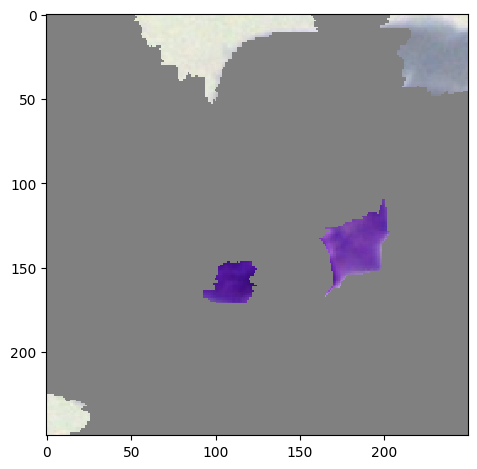

In [25]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(img,mask,superpixels))

In [28]:
perturbed_img = perturb_image(img,mask,superpixels)

# check dimensions of perturbed_img
print(perturbed_img.shape)

yhat = model.predict(perturbed_img[np.newaxis,:,:,:])
max_index = np.argmax(yhat)
print(yhat)
max_index = np.argmax(yhat)
print(class_names[max_index])

(250, 250, 3)
1/1 [==============================] - 0s 17ms/step
[[5.0470659e-16 9.3643522e-01 7.9478347e-04 9.7372634e-03 4.0247506e-03
  1.1747169e-03 1.3668986e-08 2.5671048e-05 2.5407566e-05 4.7619237e-09
  3.1859234e-03 4.1024471e-04 5.4896704e-04 2.8663111e-04 9.1641780e-04
  1.3187063e-02 2.6268786e-02 1.2698097e-03 1.0335759e-04 1.2162685e-03
  3.8879545e-04]]
ART
